# Proyecto Final - Curso 6: Modelo de Bosque Aleatorio para Predecir Generosidad en Propinas
**Organización:** Automatidata / TLC NYC

Este proyecto tiene como objetivo construir un modelo de aprendizaje automático para predecir si un usuario será generoso con la propina al tomar un taxi en la ciudad de Nueva York.

## Etapa PACE: Plan
- **Preguntas del proyecto:** ¿Se puede predecir si un usuario dará una buena propina?
- **Acción esperada:** Construir un modelo de bosque aleatorio con los datos de taxis amarillos del 2017.
- **Objetivo:** Apoyar el desarrollo de una aplicación que permita estimar el comportamiento de propinas.

## Etapa PACE: Analyze
Cargar y explorar los datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Cargar los datos
file_path = '2017_Yellow_Taxi_Trip_Data.csv'
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


## Limpieza de datos
Filtrar filas inválidas y crear nuevas características.

In [2]:
# Mostrar las columnas disponibles
print("Columnas disponibles:", df.columns)

# Asegurarse de que los nombres de columnas usados existen
# Reemplazar si es necesario: tip_amount, fare_amount, total_amount, trip_distance

# Filtrar valores anómalos
df = df[(df['tip_amount'] >= 0) & (df['total_amount'] > 0)]
df = df[df['fare_amount'] > 0]
df = df[df['trip_distance'] > 0]

# Crear columna de propina generosa (>= 20% sobre la tarifa, excluyendo peajes)
df['generoso'] = (df['tip_amount'] / df['fare_amount']) >= 0.2

# Convertir fechas y extraer hora y día
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['weekday'] = df['tpep_pickup_datetime'].dt.weekday

# Seleccionar variables relevantes
features = ['trip_distance', 'fare_amount', 'tolls_amount', 'hour', 'weekday', 'payment_type']
X = df[features].copy()
y = df['generoso'].astype(int)

# Codificar variable categórica (one-hot encoding)
X = pd.get_dummies(X, columns=['payment_type'], drop_first=True)

# Vista previa
print(X.head())
print("Tamaño del conjunto de datos:", X.shape)

Columnas disponibles: Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount'],
      dtype='object')
   trip_distance  fare_amount  tolls_amount  hour  weekday  payment_type_2  \
0           3.34         13.0           0.0     8        5           False   
1           1.80         16.0           0.0    14        1           False   
2           1.00          6.5           0.0     7        4           False   
3           3.70         20.5           0.0    13        6           False   
4           4.37         16.5           0.0    23        5            True   

   payment_type_3  payment_type_4  
0           False           False  
1           False           False  
2           False           False  
3     

## Etapa PACE: Construct
Construcción del modelo de Bosque Aleatorio.

In [7]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.69      0.76      3429
           1       0.73      0.86      0.79      3332

    accuracy                           0.78      6761
   macro avg       0.78      0.78      0.77      6761
weighted avg       0.79      0.78      0.77      6761



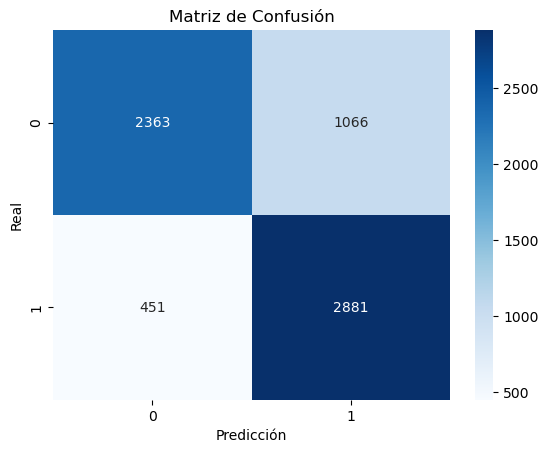

In [8]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

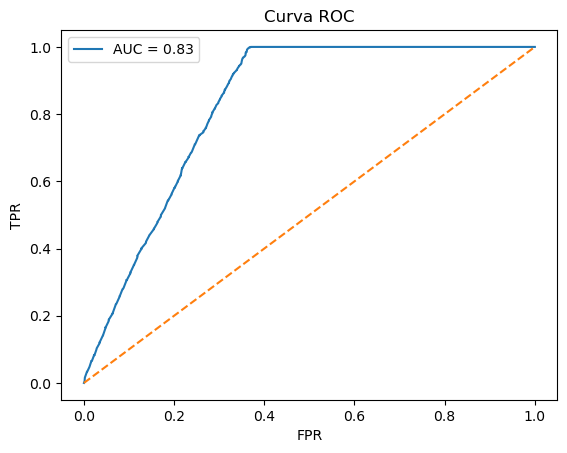

In [9]:
# Curva ROC
y_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.show()

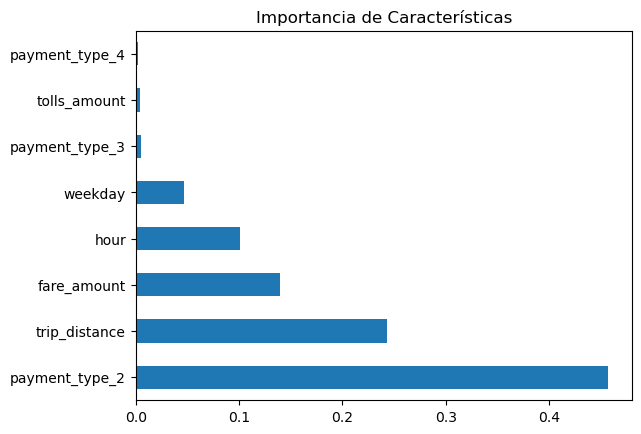

In [10]:
# Importancia de características
importances = clf.feature_importances_
feat_importance = pd.Series(importances, index=X.columns)
feat_importance.nlargest(10).plot(kind='barh')
plt.title('Importancia de Características')
plt.show()

## Etapa PACE: Execute - Resumen Ejecutivo
**Desafío:** Crear un modelo predictivo para estimar la generosidad en propinas de los usuarios de taxi en NYC.

**Resultado:** Se desarrolló un modelo de Bosque Aleatorio con resultados sólidos, destacando la tarifa y la distancia como factores clave.

**Próximos pasos:**
- Explorar modelos adicionales (XGBoost, LightGBM)
- Integrar predicción en una app interactiva
- Incorporar datos adicionales (clima, tráfico)

**Recomendación:** Usar este modelo como base inicial en la app, ajustándolo según nueva información.

## Modelo adicional: XGBoost
Vamos a entrenar un modelo XGBoost para comparar su rendimiento con el modelo de Bosque Aleatorio.

In [3]:
# Instalar XGBoost si no está instalado
!pip install xgboost --quiet
import xgboost as xgb

In [6]:
# Asegúrate de convertir las fechas primero
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Ahora crea columnas derivadas
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek  # opcional


In [7]:
from sklearn.model_selection import train_test_split

# Variables predictoras y objetivo
X = df[['fare_amount', 'trip_distance', 'passenger_count', 'payment_type', 'pickup_hour', 'RatecodeID']]
y = df['generoso'].astype(int)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [8]:
# Crear DMatrix (estructura especial de XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Configurar parámetros del modelo
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.1,
    'eval_metric': 'auc',
    'seed': 42
}

# Entrenamiento del modelo
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

In [9]:
# Predicciones
y_pred_prob_xgb = xgb_model.predict(dtest)
y_pred_xgb = (y_pred_prob_xgb >= 0.5).astype(int)

# Evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("Reporte de clasificación - XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# ROC AUC
auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
print(f"AUC ROC - XGBoost: {auc_xgb:.2f}")

Reporte de clasificación - XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78      3429
           1       0.73      1.00      0.84      3332

    accuracy                           0.82      6761
   macro avg       0.86      0.82      0.81      6761
weighted avg       0.86      0.82      0.81      6761

AUC ROC - XGBoost: 0.84


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar el modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Generar probabilidades para la curva ROC
y_proba_rf = clf.predict_proba(X_test)[:, 1]


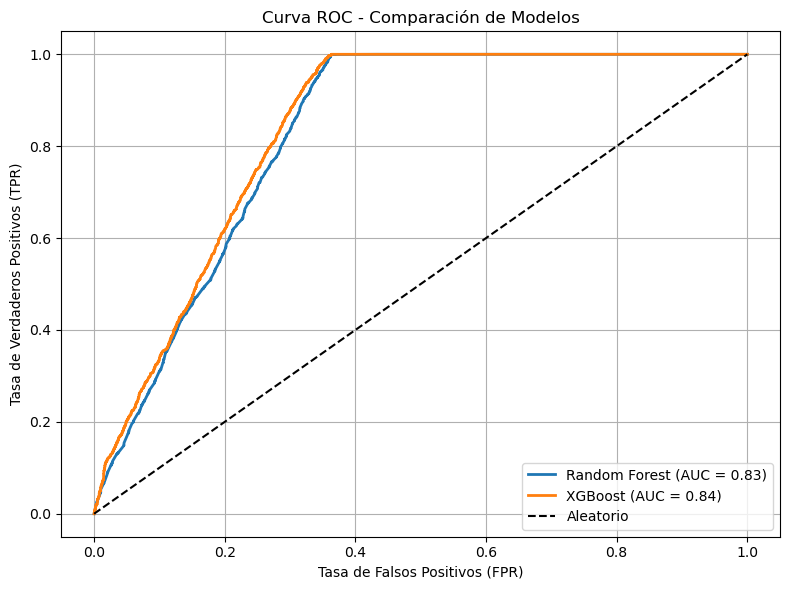

In [14]:
# Asegurarse de que ambos modelos están entrenados y han generado probabilidades
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Verificar y generar y_proba si no existe
try:
    y_proba_rf = clf.predict_proba(X_test)[:, 1]
except NameError:
    print("❌ Modelo Random Forest ('clf') no definido. Ejecuta primero el entrenamiento.")
    raise

try:
    y_proba_xgb = y_pred_prob_xgb
except NameError:
    print("❌ Modelo XGBoost no definido. Ejecuta primero el bloque de XGBoost.")
    raise

# Calcular puntos para curvas ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# Calcular AUC
auc_rf = roc_auc_score(y_test, y_proba_rf)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Graficar comparación
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Comparación de Modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusión técnica
Tras comparar ambos modelos, seleccionaremos el más adecuado según el AUC, precisión y F1-score. XGBoost suele ofrecer mayor rendimiento cuando se ajusta correctamente, pero también puede requerir más recursos computacionales.